<h1>Extract Avulsion Site Slope and Plot Long Profiles</h1>

This notebook plots combined SRTM and ALOS3D surface models for each river, corresponding channel networks and avulsion locations
to measure the distance upstream an avulsion site + calculate local slope

<h2> Method </h2>
Slopes are measured every 5000 m, which are then binned into 25 km non-overlapping windows. The median and IQR of the 5 slopes within a chosen window are then used as representative slopes

In [1]:
import os
import csv
import glob
import fiona
import rasterio
import rasterio.plot as rp
import numpy as np
import matplotlib as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy import stats, signal
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint, Point
import json
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

channel_iqr_profiles = './profiles'
channel_iqr_profiles_nofilter = './profiles_no_filter'
channel_iqr_profiles_combined = './profiles/combined'
channel_planforms = './river_profiles/parent_channel_courses/UTM'
slope_window_m = 20000 # Every 25 km bin the slopes

minslope = 1e-5 # For nan slopes

output_dir = './elevation_data'
profile_suffix = ['_SRTM3', '_AW3D30']

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

def hillshade(delta, axes):
    with rasterio.open(delta) as d:
            dem = d.read(1)
            dem = dem.astype(rasterio.float32)
            dem[dem==0] = np.nan
            cmap = plt.cm.twilight_shifted
            scalebar = ScaleBar(d.transform[0]/22) # 1 pixel = 0.2 meter
            axes.add_artist(scalebar)
            rp.show(dem, ax=axes, cmap=cmap, transform=d.transform)
    
def raster_values(x_list,y_list, start_x, start_y, band,affine, start_reference=True):
    
    # Check beginning and last nodes to get the correct ordering
    
    d_start = math.hypot(start_x - x_list[0], start_y - y_list[0])
    d_end = math.hypot(start_x - x_list[-1], start_y - y_list[-1])
        
    if d_start > d_end:
        x_list = list(x_list)
        y_list = list(y_list)
        x_list.reverse()
        y_list.reverse()
        
    row, col = ~affine * (np.array(x_list), np.array(y_list)) # x, y to raster coords
    
    dims = band.shape
    
    coord_distances = []
    rasters_vals = []
    
    for x, y in zip(row, col):
        
        c = x.astype(int)
        r = y.astype(int)
        
        #if c < dims[0] and r < dims[1]:
            
        rasters_vals.append(band[r,c])
    
    
    cumulative_distance = []
    
    for n, x in enumerate(x_list):
        if n == 0:
            if start_reference:
                cumulative_distance.append(math.hypot(start_x - x, start_y - y_list[n]))
            else:
                cumulative_distance.append(0)
        else:
            cumulative_distance.append(cumulative_distance[n-1]+(math.hypot(x_list[n-1] - x, y_list[n-1] - y_list[n])))

    return rasters_vals, cumulative_distance, x_list, y_list

def get_closest_value(arr, target):
    n = len(arr)
    left = 0
    right = n - 1
    mid = 0

    # edge case - last or above all
    if target >= arr[n - 1]:
        return arr[n - 1]
    # edge case - first or below all
    if target <= arr[0]:
        return arr[0]
    # BSearch solution: Time & Space: Log(N)

    while left < right:
        mid = (left + right) // 2  # find the mid
        if target < arr[mid]:
            right = mid
        elif target > arr[mid]:
            left = mid + 1
        else:
            return arr[mid]

    if target < arr[mid]:
        return find_closest(arr[mid - 1], arr[mid], target)
    else:
        return find_closest(arr[mid], arr[mid + 1], target)


# findClosest
# We find the closest by taking the difference
# between the target and both values. It assumes
# that val2 is greater than val1 and target lies
# between these two. 
def find_closest(val1, val2, target):
    return val2 if target - val1 >= val2 - target else val1

def get_local_slope(x, y, interp=100, window=1000):
    
    new_x = list(range(int(min(x))+1, int(max(x))-1, interp))
    f = interp1d(x, y)
    new_y = f(new_x)
    
    slope_x = []
    slopes = []
    
    x_in_range = True
    x_target = min(new_x)
    
    while x_in_range is True:
        
        x_target +=window
        
        if x_target < max(new_x):
            
            start_val = get_closest_value(new_x, x_target-window)
            nearest_next_val = get_closest_value(new_x, x_target)
            start_idx = new_x.index(start_val)
            end_idx = new_x.index(nearest_next_val)
            query_d = new_x[start_idx:end_idx]
            mid_x = int((end_idx-start_idx)/2)
            query_z = new_y[start_idx:end_idx]
            
            rise = query_z[-1]-query_z[0]
            run = query_d[-1]-query_d[0]
            slope = rise/run
#             slope, intercept, r_value, p_value, std_err = stats.linregress(query_d,query_z)
            slopes.append(slope)
            slope_x.append(query_d[mid_x])
            
        else:
            x_in_range = False
    
    return slope_x, slopes

def get_slope_windows(delta_name, slope_binned, av_idx):
    
    down_wins = slope_windows[delta_name][0]
    up_wins = slope_windows[delta_name][1]
    
    downstream_idxs = False
    upstream_idxs = False
    
    upstream_idxs = list(range(av_idx+up_wins[0],av_idx+up_wins[1]))
    upstream_slopes = slope_binned.iloc[upstream_idxs]
    downstream_slopes = slope_binned.iloc[av_idx]
    downstream_idxs = [av_idx]

    return upstream_slopes, downstream_slopes, upstream_idxs, downstream_idxs

In [2]:
# Get Avulsion Distances using channel line vectors and avulsion point locations

import os
from shapely.geometry import shape, mapping, Point, LineString
from shapely.ops import nearest_points
from glob import glob
import pandas as pd

from pyproj import CRS
crs_4326 = CRS.from_epsg(4326)

avulsion_db = pd.read_csv(os.path.join('avulsion_locations', 'avulsion_db_4326_slope_param.csv'))

channel_paths = os.path.join('river_profiles', 'parent_channel_courses', 'UTM_interpolated')
downstream_channel_paths = os.path.join('river_profiles', 'parent_channel_courses', 'downstream_UTM_interpolated')
closest_points = os.path.join('avulsion_locations', 'closest_on_channel')
os.makedirs(closest_points, exist_ok=True)
os.makedirs(downstream_channel_paths, exist_ok=True)

avulsion_distances_static = {}

width_multiple = 50

missing_channel_data = []
missing_avulsion_loc_data = []

only = ['VENEZ1']

for idx, av in avulsion_db.iterrows():
    
    if not av.AV_ID in only:
        continue
        
    channel_path_file = os.path.join(channel_paths, av.AV_ID+'_'+str(av.year_est)+'_interpolated'+profile_suffix[0]+'.geojson')
    if not os.path.exists(channel_path_file):
        print(channel_path_file+' does not exist')
        channel_path_file = os.path.join(channel_paths, av.AV_ID+'_interpolated'+profile_suffix[0]+'.geojson')
        if not os.path.exists(channel_path_file):
            print(channel_path_file+' does not exist')
            print("Cannot find channel path file for "+av.AV_ID)
            print("Year est "+str(av.year_est))
            missing_channel_data.append(os.path.basename(channel_path_file))
            continue
        else:
            print('Found '+channel_path_file)
            
    avulsion_location_file = os.path.join('./avulsion_locations', av.AV_ID+'_'+str(av.year_est)+'.shp')
    if not os.path.exists(avulsion_location_file):
        avulsion_location_file = os.path.join('./avulsion_locations', av.AV_ID+'.shp')
        if not os.path.exists(avulsion_location_file):
            print("Cannot find avulsion location file for "+av.AV_ID)
            print("Year est "+str(av.year_est))
            missing_avulsion_loc_data.append(os.path.basename(avulsion_location_file))
            continue
        else:
            print('Found '+avulsion_location_file)
            
    if len(channel_path_file) + len(avulsion_location_file) >= 2:
        
        with fiona.open(channel_path_file) as ch_file:

            river_channel_path = next(iter(ch_file))
            
            river=shape(river_channel_path['geometry'])   
                
            with fiona.open(avulsion_location_file) as av_file:
                av_point = shape(next(iter(av_file))['geometry'])
                
                nearest_geom = nearest_points(av_point, river)[1]
                nearest_geom_coords = mapping(nearest_geom)
                
                av_idx = False
                coord_distances = [] # Distances between river points and nearest coord
                for profile in river_channel_path['geometry']['coordinates']:
                    for cidx, coord in enumerate(profile):
                        coord_distances.append(Point(coord).distance(nearest_geom))
                
                av_idx = coord_distances.index(min(coord_distances))
                
                if not av.reverse_needed:
                    downstream_points = profile[0:av_idx]
                else:
                    downstream_points = profile[av_idx:len(profile)]
                
                downstream_channel_line = LineString(downstream_points)

                downstream_channel_paths_out = os.path.join(downstream_channel_paths, os.path.basename(channel_path_file))
                downstream_channel = { "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiLineString", "coordinates": [downstream_points]}}
                
                with fiona.open(downstream_channel_paths_out, 'w', schema=ch_file.schema, crs=ch_file.crs, driver='GeoJSON') as dst:
                    dst.write(downstream_channel)
                                
                closest_points_out = os.path.join(closest_points, os.path.basename(avulsion_location_file)[:-4]+'.shp')
                
                if os.path.exists(closest_points_out):
                    os.remove(closest_points_out)
                    
                    
                new_schema = { 
                  'geometry': 'Point', 
                  'properties': { 'id': 'int:10', 'distance': 'int:10'}
                }                
                avulsion_len = round(downstream_channel_line.length)
                av_id = av.AV_ID+'_'+str(av.year_est)
                avulsion_distances_static[av_id] = [avulsion_len]
                with fiona.open(closest_points_out, 'w', schema=new_schema,
                               crs=CRS.from_dict(av_file.crs).to_proj4(), driver='ESRI Shapefile') as dst:
                    feat = {
                        'type': 'Point',
                        'properties': {
                            'id': 1,
                            'distance':avulsion_len
                        },
                        'geometry': mapping(nearest_geom)
                    }
                    dst.write(feat)
                    
                
print(avulsion_distances_static)       


{'VENEZ1_1982': [10356]}


/usr/local/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.9/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
<ipython-input-2-66fa5b560180>:107: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-sys

In [3]:
set(missing_channel_data)

set()

In [4]:
set(missing_avulsion_loc_data)

set()

In [5]:
list(avulsion_distances_static.keys())

['VENEZ1_1982']

In [6]:
sample_n = len(list(avulsion_distances_static.keys())) # Without madagascar and global comp

# mad_and_global_n = 14

print('Final Count:')
print(sample_n)

Final Count:
1


AFR0211 not in avulsion_distances_static, skipping
ANGO2 not in avulsion_distances_static, skipping
ARG_001 not in avulsion_distances_static, skipping
BETSIBOKA not in avulsion_distances_static, skipping
BS0115 not in avulsion_distances_static, skipping
CA0067 not in avulsion_distances_static, skipping
CA0194 not in avulsion_distances_static, skipping
CA0318-1 not in avulsion_distances_static, skipping
CASP1 not in avulsion_distances_static, skipping
CHI_001 not in avulsion_distances_static, skipping
CON_001 not in avulsion_distances_static, skipping
CON_002 not in avulsion_distances_static, skipping
DANUBE not in avulsion_distances_static, skipping
ECN0095 not in avulsion_distances_static, skipping
FIHERENANA not in avulsion_distances_static, skipping
HUANGHE not in avulsion_distances_static, skipping
JA_1_Taquari_1990 not in avulsion_distances_static, skipping
JA_10_Iran_2009 not in avulsion_distances_static, skipping
JA_12_Eritrea not in avulsion_distances_static, skipping
JA_18_PNG

<Figure size 872.504x440.504 with 0 Axes>

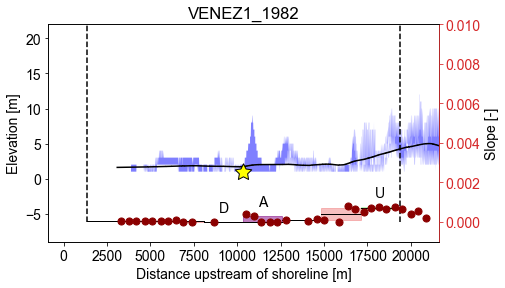

VENEZ2 not in avulsion_distances_static, skipping
VENEZ2 not in avulsion_distances_static, skipping
AFR0211 not in avulsion_distances_static, skipping
ANGO2 not in avulsion_distances_static, skipping
ARG_001 not in avulsion_distances_static, skipping
BETSIBOKA not in avulsion_distances_static, skipping
BS0115 not in avulsion_distances_static, skipping
CA0067 not in avulsion_distances_static, skipping
CA0194 not in avulsion_distances_static, skipping
CA0318-1 not in avulsion_distances_static, skipping
CASP1 not in avulsion_distances_static, skipping
CHI_001 not in avulsion_distances_static, skipping
CON_001 not in avulsion_distances_static, skipping
CON_002 not in avulsion_distances_static, skipping
DANUBE not in avulsion_distances_static, skipping
ECN0095 not in avulsion_distances_static, skipping
FIHERENANA not in avulsion_distances_static, skipping
HUANGHE not in avulsion_distances_static, skipping
JA_1_Taquari_1990 not in avulsion_distances_static, skipping
JA_10_Iran_2009 not in av

<Figure size 872.504x440.504 with 0 Axes>

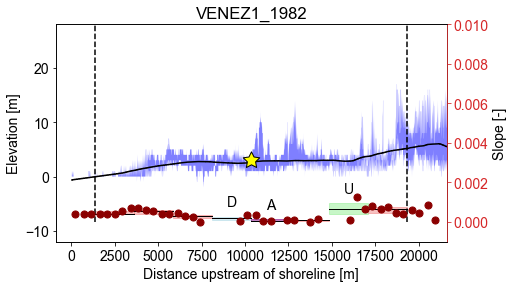

VENEZ2 not in avulsion_distances_static, skipping
VENEZ2 not in avulsion_distances_static, skipping
2
2
         Av_ID      River  Year   From  L_A [km]  L_A_error [km]  \
0  VENEZ1_1982  Catatumbo  1982  study    10.356               0   
1  VENEZ1_1982  Catatumbo  1982  study    10.356               0   

   Upstream S [-]  Upstream S_IQR [-]  Downstream S [-]  Downstream S_IQR [-]  \
0        0.000715            0.000077      5.551115e-19              0.000000   
1        0.000664            0.000573      1.977189e-04              0.000151   

   Immediate Upstream S [-]  Immediate Upstream S_IQR [-]  \
0                  0.000016                      0.000282   
1                  0.000076                      0.000093   

   Total Rise Over Run Filter  
0              0.00021     no  
1              0.00039    yes  


In [7]:
# WITH FILTER
os.makedirs('./figures/profiles/', exist_ok=True)
os.makedirs('./figures/profiles/smoothed', exist_ok=True)

import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.interpolate import interp1d

# To be populated
upstream_slopes = []
upstream_slopes_IQR = []
downstream_slopes = []
downstream_slopes_IQR = []
immediate_upstream_slopes = []
immediate_upstream_slopes_IQR = []
total_rise_over_run = []
from_list = []
with_filter = []

La_list = []
avulsion_ids = []
avulsion_names = []
avulsion_years = []

fig_width_cm = 25.7                              # A4 page
fig_height_cm = 13
inches_per_cm = 1 / 2.54                         # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm         # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig_size = [fig_width+2, fig_height+1]

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42 # Truetype so text can be edited in Adobe Illustrator 
    
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(fig_size)
gspec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

upstream_slope_len = 5000 # metres

chunks = 3
av_inc_list = []
av_inc = 0

av_keys = list(avulsion_distances_static.keys())

for idx, riv in avulsion_db.iterrows():
    
    if riv.slope_process == 0:
        continue
    
    avulsion_id = riv.AV_ID+'_'+str(riv.year_est)
    

    if avulsion_id not in av_keys:
        avulsion_id = riv.AV_ID

    try:
        avulsion_distances_static[avulsion_id]
    except:
        print(avulsion_id+' not in avulsion_distances_static, skipping')
        continue
        
    print(avulsion_id)
    
    if riv.year_est > 0:
        save_avulsion_id = riv.AV_ID+'_'+str(riv.year_est)
    else:
        save_avulsion_id = riv.AV_ID
    
    wbf = riv.Wbf # Metres
    
    print('River width: '+str(wbf)+' m')
    skip = False
    elev_data_combined = pd.DataFrame()
    for ps in profile_suffix:
    
        if os.path.exists(os.path.join(channel_iqr_profiles, avulsion_id+'_profile.csv')):
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, avulsion_id+'_profile'+ps+'.csv'))
        elif os.path.exists(os.path.join(channel_iqr_profiles, avulsion_id+'_profile'+ps+'.csv')):
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, avulsion_id+'_profile'+ps+'.csv'))
        elif os.path.exists(os.path.join(channel_iqr_profiles, riv.AV_ID+'_profile'+ps+'.csv')):
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, riv.AV_ID+'_profile'+ps+'.csv'))
        elif os.path.exists(os.path.join(channel_iqr_profiles, save_avulsion_id+'_profile'+ps+'.csv')):
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, save_avulsion_id+'_profile'+ps+'.csv'))
        else:
            print('CANNOT FIND PROFILE FOR '+avulsion_id)
            print('tried...')
            print(os.path.join(channel_iqr_profiles, avulsion_id+'_profile.csv'))
            print(os.path.join(channel_iqr_profiles, avulsion_id+'_profile'+ps+'.csv'))
            print(os.path.join(channel_iqr_profiles, riv.AV_ID+'_profile'+ps+'.csv'))
            print(os.path.join(channel_iqr_profiles, save_avulsion_id+'_profile'+ps+'.csv'))
            skip = True
        
        elev_data_combined = elev_data_combined.append(elev_data)
    
    if skip:
        continue
        
    avulsion_ids.append(save_avulsion_id)
    avulsion_names.append(riv.river_name)
    avulsion_years.append(riv.year_est)
    with_filter.append('no')
    from_list.append(riv['from'])
    
    av_inc_list.append(av_inc)
    av_inc = av_inc+1
    
    elev_data_combined = elev_data_combined[elev_data_combined['median'] != 'nan'] # Remove non numerics
    elev_data_combined = elev_data_combined[elev_data_combined['median'] <= 5000] # Remove invalid data (nodata is usually a high int)
    elev_data_combined = elev_data_combined[elev_data_combined['stdev'] <= 20] # Any data with a stdev greater than 20 is spurious
    elev_data_combined = elev_data_combined.sort_values('distance')
    elev_data_combined.reset_index(drop=True)

    if riv.reverse_needed:
        elev_data_combined['distance'] = abs(elev_data_combined['distance']-(np.max(elev_data_combined['distance'])))
    
    # Calculate total rise over run
    rise = np.max(elev_data_combined['median'])-np.min(elev_data_combined['median'])
    run = np.max(elev_data_combined['distance'])
    total_rise_over_run.append(rise/run)
    
    if np.isnan(riv.min_elevations_m):
        min_height = np.nanmin(elev_data_combined['prc_25']-10)
    else:
        min_height = riv.min_elevations_m
    
    if np.isnan(riv.max_elevations_m):
        max_height = np.nanmax(elev_data_combined['prc_75']+10)
    else:
        max_height = riv.max_elevations_m

    if np.isnan(riv.min_distances_km):
        min_dist_m = np.nanin(elev_data_combined['distance'])
        min_dist_km = np.nanmin(elev_data_combined['distance'])/1000
    else:
        min_dist_m = riv.min_distances_km*1000
        min_dist_km = riv.min_distances_km
    
    if np.isnan(riv.max_distances_km):
        max_dist_m = np.nanmax(elev_data_combined['distance'])
        max_dist_km = np.nanmax(elev_data_combined['distance'])/1000
    else:
        max_dist_m = riv.max_distances_km*1000
        max_dist_km = riv.max_distances_km

    
    local_slope = []
    central_distances = []


    fig_profile, ax_profile = plt.subplots(figsize=(7,4))
    axb = ax_profile.twinx()  # instantiate a second axes that shares the same x-axis

    distance_km = [x / 1000 for x in elev_data_combined['distance']]

    La_list.append(avulsion_distances_static[avulsion_id][0]/1000)

    av_idxs = []
    av_dists = []
    av_elevs = []

    #slope_window_m = riv.avulsion_slope_distances_upstream
    slope_window_m = (wbf*width_multiple)/chunks 
    slope_window_full = (wbf*width_multiple)
    
    slope_measure_window = slope_window_m/5 # 5 slope measurements per bin
    
    if slope_measure_window < 150:
        slope_measure_window = 150 # Use 150 metres a minimum 
    
    print('slope bin limit = '+str(slope_window_full))
    print('slope bin size = '+str(slope_window_m))
    print('slope measure window = '+str(slope_measure_window))
    
    for av_dist in avulsion_distances_static[avulsion_id]:
        av_idx_m = abs(elev_data_combined['distance'] - av_dist).idxmin()
        av_idxs.append(av_idx_m)
        av_elevs.append(float(elev_data_combined.iloc[av_idx_m]['median']))

    max_dist_idx = (np.abs(np.array(distance_km) - max_dist_km)).argmin()
    
    print('Savitsky Golay smoothing window = '+str(riv.smoothing_windows))
    
    smoothed_elevation = signal.savgol_filter(elev_data_combined['median'], riv.smoothing_windows, 1)    
    # Only plot upstream of elevation
    # elev_data_gt_av = (elev_data_combined['distance']> avulsion_distances_static[avulsion_id][0])
    # slope_x, slopes = get_local_slope(elev_data_combined['distance'][elev_data_gt_av], smoothed_elevation[elev_data_gt_av], window=1000) # Per m
    
    
    slope_x, slopes = get_local_slope(elev_data_combined['distance'], smoothed_elevation, window=slope_measure_window) # Per m
    
    # Put into a dataframe
    slope_df = pd.DataFrame(list(zip(slope_x, slopes)), columns = ['x', 'slope'])
    slope_df = slope_df[slope_df['slope'] > 0] # Remove invalid data
    slope_df.reset_index(drop=True)

    # Plot local slope on profile axis

    ax_profile.plot(elev_data_combined['distance'],smoothed_elevation, color='black')
    
    # Write smoothed profile to csv
    smoothed_profile_dat = pd.DataFrame({'distance':elev_data_combined['distance'],'elev':smoothed_elevation})
    smoothed_profile_dat.to_csv('figures/profiles/smoothed/'+save_avulsion_id+'_with_filter.csv')
    
    axb.scatter(slope_df['x'], slope_df['slope'], 50, color='darkred', zorder=7)
    ax_profile.fill_between(elev_data_combined['distance'], elev_data_combined['prc_75'], elev_data_combined['prc_25'], facecolor='blue', alpha=0.5)
    
    if np.nanmax(slope_df['slope']) > 0.01:
        axb.set_ylim(-0.001, np.nanmax(slope_df['slope']))
    else:
        axb.set_ylim(-0.001, 0.01)

    
    for aidx, av_dist in enumerate(avulsion_distances_static[avulsion_id]):
        ax_profile.scatter(av_dist,av_elevs[aidx], s=300, marker=(5, 1), facecolors='yellow', edgecolors=(0, 0, 0), zorder=10)

    ax_profile.set_xlabel('Distance upstream of shoreline [m]')
    axb.set_ylabel('Slope [-]')
    ax_profile.set_ylabel('Elevation [m]')
    axb.spines['right'].set_color('tab:red')
    axb.tick_params(axis='y', colors='tab:red')
    ax_profile.set_title(save_avulsion_id)
#     fig_profile.savefig('./figures/profiles/'+riv+'.pdf')

    max_dist = slope_df.x.max()

    # Group slope values into windows bins
    
    if (avulsion_distances_static[avulsion_id][0]-slope_window_full) < 0:
        min_dist_slope_search = 0
    else:
        min_dist_slope_search = (avulsion_distances_static[avulsion_id][0]-slope_window_full)
        
    max_dist_slope_search = (avulsion_distances_static[avulsion_id][0]+slope_window_full)
    
    # Upstream
    wr_upstream = [avulsion_distances_static[avulsion_id][0]]
    max_len_met = False
    upstream_bin_edge = wr_upstream[0]
    while not max_len_met:
        upstream_bin_edge_new = upstream_bin_edge+slope_window_m
        wr_upstream.append(upstream_bin_edge_new)
        if upstream_bin_edge_new > max_dist_slope_search:
            max_len_met = True
        upstream_bin_edge = upstream_bin_edge_new

    # Downstream
    wr_downstream = [avulsion_distances_static[avulsion_id][0]-slope_window_m]
    min_len_met = False
    downstream_bin_edge = wr_downstream[0]
    while not min_len_met:
        downstream_bin_edge_new = downstream_bin_edge-slope_window_m
        wr_downstream.append(downstream_bin_edge_new)
        if downstream_bin_edge_new < min_dist_slope_search:
            min_len_met = True
        downstream_bin_edge = downstream_bin_edge_new
    
    wr_downstream.reverse()
    
    slope_bin_edges = np.concatenate((wr_downstream,wr_upstream))
    
    ax_profile.set_ylim(min_height, max_height)
    ax_profile.set_xlim(slope_bin_edges[0]-slope_window_m, slope_bin_edges[-1]+slope_window_m)        
    
    
    slope_window_groups = slope_df.groupby(pd.cut(slope_df["x"], slope_bin_edges))
    slope_binned = slope_window_groups.median() # Median slope for every window

    ds = slope_window_groups.std() # Slope error per window
    quart_25 = slope_window_groups.quantile(q=0.25) # 25th pctile per window
    quart_75 = slope_window_groups.quantile(q=0.75) # 75th pctile per window

    # Add columns to slope_binned to create single dataframe
    slope_binned['std'] = list(ds.slope)
    slope_binned['pct_25'] = list(quart_25.slope)
    slope_binned['pct_75'] = list(quart_75.slope)
    slope_binned['idx'] = np.arange(len(slope_binned))

    intervals = slope_binned.index.tolist()
    slope_binned.index = range(0,len(list(ds.slope)))
    slope_binned.reset_index()

    downstream_bins = slope_binned.loc[slope_binned.x<avulsion_distances_static[avulsion_id][0]]
    upstream_bins = slope_binned.loc[slope_binned.x>=avulsion_distances_static[avulsion_id][0]]
    
    print('Min slope:'+str(downstream_bins.slope.min()))
    downstream_bins_min = downstream_bins.loc[downstream_bins.slope==downstream_bins.slope.min()].head(1)
    if len(downstream_bins_min) < 1:
        print('Downstream slope not found, substituting with first upstream bin')
        downstream_bins_min = upstream_bins[upstream_bins.x == upstream_bins.x.min()].head(1)
        
        
    print('Max slope:'+str(upstream_bins.slope.max()))
    upstream_bins_max = upstream_bins.loc[upstream_bins.slope==upstream_bins.slope.max()].head(1)
    
    print(downstream_bins_min)
    print(upstream_bins_max)
    
    # Avulsion distance upstream
    con_d = avulsion_distances_static[avulsion_id][0]                                                               
    av_idx = abs(slope_binned['x'] - con_d).idxmin() # Which bin is our avulsion in?
    bin_idx = int(slope_binned.loc[av_idx]['idx']) # Index of bin that avulsion is on
    
    # Upstream bin
    con_d_upstream = avulsion_distances_static[avulsion_id][0]+(wbf*5)                                                          
    av_idx_upstream = abs(slope_binned['x'] - con_d_upstream).idxmin() # Which bin is our avulsion in?
    
    upstream_bin_idx = upstream_bins_max.index # Index of bin that avulsion is on    
    downstream_bin_idx = downstream_bins_min.index

    # Box limits
    slope_neg_error = []
    slope_pos_error = []
    slope_val = []
    slope_center = []

    # Get maximum upstream bin slope
    upstream_slope = float(upstream_bins_max['slope'])
    upstream_slopes.append(upstream_slope)
    upstream_slope_IQR = float(upstream_bins_max['pct_75'])-float(upstream_bins_max['pct_25'])
    upstream_slopes_IQR.append(upstream_slope_IQR)

    # Get minimum downstream bin slope
    downstream_slope = float(downstream_bins_min['slope'])
    downstream_slopes.append(downstream_slope)
    downstream_slope_IQR = float(downstream_bins_min['pct_75'])-float(downstream_bins_min['pct_25'])
    downstream_slopes_IQR.append(downstream_slope_IQR)

    # Get slope immediately upstream of avulsion node
    immediate_upstream_slope_bin = slope_binned.loc[slope_binned.idx==av_idx_upstream]
    immediate_upstream_slope = float(immediate_upstream_slope_bin['slope'])
    immediate_upstream_slopes.append(immediate_upstream_slope)
    immediate_upstream_slope_IQR = float(immediate_upstream_slope_bin['pct_75'])-float(immediate_upstream_slope_bin['pct_25'])
    immediate_upstream_slopes_IQR.append(immediate_upstream_slope_IQR)
    
    
    print('Downstream slope: '+str(float(downstream_slope)))
    print('Upstream slope: '+str(float(upstream_slope)))
    print('Immediate upstream slope: '+str(float(immediate_upstream_slope_bin['slope'])))
    
    for index, row in slope_binned.iterrows():
        
        intv = intervals[index]
        b_left = intv.left
        b_right = intv.right
        b_bottom = float(row['pct_25'])
        b_top = float(row['pct_75'])
        b_width = b_right-b_left
        b_height = b_top-b_bottom

        slope_val.append(float(row['slope']))
        slope_neg_error.append(row['slope']-b_bottom)
        slope_pos_error.append(b_top-row['slope'])
        slope_center.append((b_left+b_right)/2)

        fcolor = 'lightcoral'

        upstream_slope = False
        
        if row['idx'] == upstream_bins_max.index:
            fcolor = 'lightgreen'
            axb.annotate('U', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
        
        if row['idx'] == downstream_bins_min.index:
            fcolor = 'lightblue'
            axb.annotate('D', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') 

        if row['idx'] == av_idx_upstream:
            fcolor = 'purple'
            axb.annotate('A', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') 
            
#         elif row['idx'] in dns_idxs:
#             fcolor = 'yellow'

        rect = patches.Rectangle((b_left,b_bottom),b_width,b_height,linewidth=1,
                                 edgecolor=fcolor,facecolor=fcolor, 
                                 fill=True, alpha=0.5)
    
        # Plot median value
        axb.plot([b_left, b_left+b_width], [float(row['slope']), float(row['slope'])], color='black', linewidth=1)
        
        axb.add_patch(rect)
    
    axb.plot([slope_bin_edges[-1], slope_bin_edges[-1]], [0, 0.1], 'k--')
    axb.plot([slope_bin_edges[0], slope_bin_edges[0]], [0, 0.1], 'k--')
    
    plt.savefig(os.path.join('figures', 'profiles', avulsion_id+'.png'))
    plt.show()


# WITHOUT FILTER
os.makedirs('./figures/profiles_nofilter/', exist_ok=True)

fig_width_cm = 25.7                              # A4 page
fig_height_cm = 13
inches_per_cm = 1 / 2.54                         # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm         # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig_size = [fig_width+2, fig_height+1]

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42 # Truetype so text can be edited in Adobe Illustrator 
    
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(fig_size)
gspec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

upstream_slope_len = 5000 # metres

av_keys = list(avulsion_distances_static.keys())

for idx, riv in avulsion_db.iterrows():
    
    if riv.slope_process == 0:
        continue
    
    avulsion_id = riv.AV_ID+'_'+str(riv.year_est)

    

    if avulsion_id not in av_keys:
        avulsion_id = riv.AV_ID

    try:
        avulsion_distances_static[avulsion_id]
    except:
        print(avulsion_id+' not in avulsion_distances_static, skipping')
        continue
        
    print(avulsion_id)
    
    if riv.year_est > 0:
        save_avulsion_id = riv.AV_ID+'_'+str(riv.year_est)
    else:
        save_avulsion_id = riv.AV_ID
    
    wbf = riv.Wbf # Metres
    
    print('River width: '+str(wbf)+' m')
    skip = False
    elev_data_combined = pd.DataFrame()
    for ps in profile_suffix:
    
        if os.path.exists(os.path.join(channel_iqr_profiles_nofilter, avulsion_id+'_profile.csv')):
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles_nofilter, avulsion_id+'_profile'+ps+'.csv'))
        elif os.path.exists(os.path.join(channel_iqr_profiles_nofilter, avulsion_id+'_profile'+ps+'.csv')):
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles_nofilter, avulsion_id+'_profile'+ps+'.csv'))
        elif os.path.exists(os.path.join(channel_iqr_profiles_nofilter, riv.AV_ID+'_profile'+ps+'.csv')):
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles_nofilter, riv.AV_ID+'_profile'+ps+'.csv'))
        elif os.path.exists(os.path.join(channel_iqr_profiles_nofilter, save_avulsion_id+'_profile'+ps+'.csv')):
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles_nofilter, save_avulsion_id+'_profile'+ps+'.csv'))
        else:
            print('CANNOT FIND PROFILE FOR '+avulsion_id)
            print('tried...')
            print(os.path.join(channel_iqr_profiles_nofilter, avulsion_id+'_profile.csv'))
            print(os.path.join(channel_iqr_profiles_nofilter, avulsion_id+'_profile'+ps+'.csv'))
            print(os.path.join(channel_iqr_profiles_nofilter, riv.AV_ID+'_profile'+ps+'.csv'))
            print(os.path.join(channel_iqr_profiles_nofilter, save_avulsion_id+'_profile'+ps+'.csv'))
            skip = True
        
        elev_data_combined = elev_data_combined.append(elev_data)
    
    if skip:
        continue
        
    avulsion_ids.append(save_avulsion_id)
    avulsion_names.append(riv.river_name)
    avulsion_years.append(riv.year_est)
    with_filter.append('yes')
    from_list.append(riv['from'])
    
    av_inc_list.append(av_inc)
    av_inc = av_inc+1
    
    elev_data_combined = elev_data_combined[elev_data_combined['median'] != 'nan'] # Remove non numerics
    elev_data_combined = elev_data_combined[elev_data_combined['median'] <= 5000] # Remove invalid data (nodata is usually a high int)
    elev_data_combined = elev_data_combined[elev_data_combined['stdev'] <= 20] # Any data with a stdev greater than 20 is spurious
    elev_data_combined = elev_data_combined.sort_values('distance')
    elev_data_combined.reset_index(drop=True)

    if riv.reverse_needed:
        elev_data_combined['distance'] = abs(elev_data_combined['distance']-(np.max(elev_data_combined['distance'])))
    
    # Calculate total rise over run
    rise = np.max(elev_data_combined['median'])-np.min(elev_data_combined['median'])
    run = np.max(elev_data_combined['distance'])
    total_rise_over_run.append(rise/run)
    
    if np.isnan(riv.min_elevations_m):
        min_height = np.nanmin(elev_data_combined['prc_25']-10)
    else:
        min_height = riv.min_elevations_m
    
    if np.isnan(riv.max_elevations_m):
        max_height = np.nanmax(elev_data_combined['prc_75']+10)
    else:
        max_height = riv.max_elevations_m

    if np.isnan(riv.min_distances_km):
        min_dist_m = np.nanin(elev_data_combined['distance'])
        min_dist_km = np.nanmin(elev_data_combined['distance'])/1000
    else:
        min_dist_m = riv.min_distances_km*1000
        min_dist_km = riv.min_distances_km
    
    if np.isnan(riv.max_distances_km):
        max_dist_m = np.nanmax(elev_data_combined['distance'])
        max_dist_km = np.nanmax(elev_data_combined['distance'])/1000
    else:
        max_dist_m = riv.max_distances_km*1000
        max_dist_km = riv.max_distances_km

    
    local_slope = []
    central_distances = []


    fig_profile, ax_profile = plt.subplots(figsize=(7,4))
    axb = ax_profile.twinx()  # instantiate a second axes that shares the same x-axis

    distance_km = [x / 1000 for x in elev_data_combined['distance']]

    La_list.append(avulsion_distances_static[avulsion_id][0]/1000)

    av_idxs = []
    av_dists = []
    av_elevs = []

    #slope_window_m = riv.avulsion_slope_distances_upstream
    slope_window_m = (wbf*width_multiple)/chunks 
    slope_window_full = (wbf*width_multiple)
    
    slope_measure_window = slope_window_m/5 # 5 slope measurements per bin
    
    if slope_measure_window < 150:
        slope_measure_window = 150 # Use 150 metres a minimum 
    
    print('slope bin limit = '+str(slope_window_full))
    print('slope bin size = '+str(slope_window_m))
    print('slope measure window = '+str(slope_measure_window))
    
    for av_dist in avulsion_distances_static[avulsion_id]:
        av_idx_m = abs(elev_data_combined['distance'] - av_dist).idxmin()
        av_idxs.append(av_idx_m)
        av_elevs.append(float(elev_data_combined.iloc[av_idx_m]['median']))

    max_dist_idx = (np.abs(np.array(distance_km) - max_dist_km)).argmin()
    
    print('Savitsky Golay smoothing window = '+str(riv.smoothing_windows))
    
    smoothed_elevation = signal.savgol_filter(elev_data_combined['median'], riv.smoothing_windows, 1)    
    # Only plot upstream of elevation
    # elev_data_gt_av = (elev_data_combined['distance']> avulsion_distances_static[avulsion_id][0])
    # slope_x, slopes = get_local_slope(elev_data_combined['distance'][elev_data_gt_av], smoothed_elevation[elev_data_gt_av], window=1000) # Per m
    
    slope_x, slopes = get_local_slope(elev_data_combined['distance'], smoothed_elevation, window=slope_measure_window) # Per m
    
    # Put into a dataframe
    slope_df = pd.DataFrame(list(zip(slope_x, slopes)), columns = ['x', 'slope'])
    slope_df = slope_df[slope_df['slope'] > 0] # Remove invalid data
    slope_df.reset_index(drop=True)

    # Plot local slope on profile axis

    ax_profile.plot(elev_data_combined['distance'],smoothed_elevation, color='black')
    
    # Write smoothed profile to csv
    smoothed_profile_dat = pd.DataFrame({'distance':elev_data_combined['distance'],'elev':smoothed_elevation})
    smoothed_profile_dat.to_csv('figures/profiles/smoothed/'+save_avulsion_id+'_without_filter.csv')
    
    axb.scatter(slope_df['x'], slope_df['slope'], 50, color='darkred', zorder=7)
    ax_profile.fill_between(elev_data_combined['distance'], elev_data_combined['prc_75'], elev_data_combined['prc_25'], facecolor='blue', alpha=0.5)
    
    if np.nanmax(slope_df['slope']) > 0.01:
        axb.set_ylim(-0.001, np.nanmax(slope_df['slope']))
    else:
        axb.set_ylim(-0.001, 0.01)

    
    for aidx, av_dist in enumerate(avulsion_distances_static[avulsion_id]):
        ax_profile.scatter(av_dist,av_elevs[aidx], s=300, marker=(5, 1), facecolors='yellow', edgecolors=(0, 0, 0), zorder=10)

    ax_profile.set_xlabel('Distance upstream of shoreline [m]')
    axb.set_ylabel('Slope [-]')
    ax_profile.set_ylabel('Elevation [m]')
    axb.spines['right'].set_color('tab:red')
    axb.tick_params(axis='y', colors='tab:red')
    ax_profile.set_title(save_avulsion_id)
#     fig_profile.savefig('./figures/profiles/'+riv+'.pdf')

    max_dist = slope_df.x.max()

    # Group slope values into windows bins
    
    if (avulsion_distances_static[avulsion_id][0]-slope_window_full) < 0:
        min_dist_slope_search = 0
    else:
        min_dist_slope_search = (avulsion_distances_static[avulsion_id][0]-slope_window_full)
        
    max_dist_slope_search = (avulsion_distances_static[avulsion_id][0]+slope_window_full)
    
    # Upstream
    wr_upstream = [avulsion_distances_static[avulsion_id][0]]
    max_len_met = False
    upstream_bin_edge = wr_upstream[0]
    while not max_len_met:
        upstream_bin_edge_new = upstream_bin_edge+slope_window_m
        wr_upstream.append(upstream_bin_edge_new)
        if upstream_bin_edge_new > max_dist_slope_search:
            max_len_met = True
        upstream_bin_edge = upstream_bin_edge_new

    # Downstream
    wr_downstream = [avulsion_distances_static[avulsion_id][0]-slope_window_m]
    min_len_met = False
    downstream_bin_edge = wr_downstream[0]
    while not min_len_met:
        downstream_bin_edge_new = downstream_bin_edge-slope_window_m
        wr_downstream.append(downstream_bin_edge_new)
        if downstream_bin_edge_new < min_dist_slope_search:
            min_len_met = True
        downstream_bin_edge = downstream_bin_edge_new
    
    wr_downstream.reverse()
    
    slope_bin_edges = np.concatenate((wr_downstream,wr_upstream))
    
    ax_profile.set_ylim(min_height, max_height)
    ax_profile.set_xlim(slope_bin_edges[0]-slope_window_m, slope_bin_edges[-1]+slope_window_m)        
    
    
    slope_window_groups = slope_df.groupby(pd.cut(slope_df["x"], slope_bin_edges))
    slope_binned = slope_window_groups.median() # Median slope for every window

    ds = slope_window_groups.std() # Slope error per window
    quart_25 = slope_window_groups.quantile(q=0.25) # 25th pctile per window
    quart_75 = slope_window_groups.quantile(q=0.75) # 75th pctile per window

    # Add columns to slope_binned to create single dataframe
    slope_binned['std'] = list(ds.slope)
    slope_binned['pct_25'] = list(quart_25.slope)
    slope_binned['pct_75'] = list(quart_75.slope)
    slope_binned['idx'] = np.arange(len(slope_binned))

    intervals = slope_binned.index.tolist()
    slope_binned.index = range(0,len(list(ds.slope)))
    slope_binned.reset_index()

    downstream_bins = slope_binned.loc[slope_binned.x<avulsion_distances_static[avulsion_id][0]]
    upstream_bins = slope_binned.loc[slope_binned.x>=avulsion_distances_static[avulsion_id][0]]
    
    print('Min slope:'+str(downstream_bins.slope.min()))
    downstream_bins_min = downstream_bins.loc[downstream_bins.slope==downstream_bins.slope.min()].head(1)
    if len(downstream_bins_min) < 1:
        print('Downstream slope not found, substituting with first upstream bin')
        downstream_bins_min = upstream_bins[upstream_bins.x == upstream_bins.x.min()].head(1)
        
        
    print('Max slope:'+str(upstream_bins.slope.max()))
    upstream_bins_max = upstream_bins.loc[upstream_bins.slope==upstream_bins.slope.max()].head(1)
    
    print(downstream_bins_min)
    print(upstream_bins_max)
    
    # Avulsion distance upstream
    con_d = avulsion_distances_static[avulsion_id][0]                                                               
    av_idx = abs(slope_binned['x'] - con_d).idxmin() # Which bin is our avulsion in?
    bin_idx = int(slope_binned.loc[av_idx]['idx']) # Index of bin that avulsion is on
    
    # Upstream bin
    con_d_upstream = avulsion_distances_static[avulsion_id][0]+(wbf*5)                                                          
    av_idx_upstream = abs(slope_binned['x'] - con_d_upstream).idxmin() # Which bin is our avulsion in?
    
    upstream_bin_idx = upstream_bins_max.index # Index of bin that avulsion is on    
    downstream_bin_idx = downstream_bins_min.index

    # Box limits
    slope_neg_error = []
    slope_pos_error = []
    slope_val = []
    slope_center = []

    # Get maximum upstream bin slope
    upstream_slope = float(upstream_bins_max['slope'])
    upstream_slopes.append(upstream_slope)
    upstream_slope_IQR = float(upstream_bins_max['pct_75'])-float(upstream_bins_max['pct_25'])
    upstream_slopes_IQR.append(upstream_slope_IQR)

    # Get minimum downstream bin slope
    downstream_slope = float(downstream_bins_min['slope'])
    downstream_slopes.append(downstream_slope)
    downstream_slope_IQR = float(downstream_bins_min['pct_75'])-float(downstream_bins_min['pct_25'])
    downstream_slopes_IQR.append(downstream_slope_IQR)

    # Get slope immediately upstream of avulsion node
    immediate_upstream_slope_bin = slope_binned.loc[slope_binned.idx==av_idx_upstream]
    immediate_upstream_slope = float(immediate_upstream_slope_bin['slope'])
    immediate_upstream_slopes.append(immediate_upstream_slope)
    immediate_upstream_slope_IQR = float(immediate_upstream_slope_bin['pct_75'])-float(immediate_upstream_slope_bin['pct_25'])
    immediate_upstream_slopes_IQR.append(immediate_upstream_slope_IQR)
    
    
    print('Downstream slope: '+str(float(downstream_slope)))
    print('Upstream slope: '+str(float(upstream_slope)))
    print('Immediate upstream slope: '+str(float(immediate_upstream_slope_bin['slope'])))
    
    for index, row in slope_binned.iterrows():
        
        intv = intervals[index]
        b_left = intv.left
        b_right = intv.right
        b_bottom = float(row['pct_25'])
        b_top = float(row['pct_75'])
        b_width = b_right-b_left
        b_height = b_top-b_bottom

        slope_val.append(float(row['slope']))
        slope_neg_error.append(row['slope']-b_bottom)
        slope_pos_error.append(b_top-row['slope'])
        slope_center.append((b_left+b_right)/2)

        fcolor = 'lightcoral'

        upstream_slope = False
        
        if row['idx'] == upstream_bins_max.index:
            fcolor = 'lightgreen'
            axb.annotate('U', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
        
        if row['idx'] == downstream_bins_min.index:
            fcolor = 'lightblue'
            axb.annotate('D', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') 

        if row['idx'] == av_idx_upstream:
            fcolor = 'purple'
            axb.annotate('A', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') 
            
#         elif row['idx'] in dns_idxs:
#             fcolor = 'yellow'

        rect = patches.Rectangle((b_left,b_bottom),b_width,b_height,linewidth=1,
                                 edgecolor=fcolor,facecolor=fcolor, 
                                 fill=True, alpha=0.5)
    
        # Plot median value
        axb.plot([b_left, b_left+b_width], [float(row['slope']), float(row['slope'])], color='black', linewidth=1)
        
        axb.add_patch(rect)
    
    axb.plot([slope_bin_edges[-1], slope_bin_edges[-1]], [0, 0.1], 'k--')
    axb.plot([slope_bin_edges[0], slope_bin_edges[0]], [0, 0.1], 'k--')
    
    plt.savefig(os.path.join('figures', 'profiles_nofilter', avulsion_id+'.png'))
    plt.show()
    
# Av_ID	River	From	LA [km]	S [-]	S_std [-]	D50 [m] (recorded)	Hbf [m] (recorded)	Hbf_std [m] (recorded)	Width [m]	DIS_AV_CMS	Cf	t_scour

print(len(avulsion_names))
print(len(avulsion_years))
avulsion_db_new = pd.DataFrame({
    'Av_ID':avulsion_ids,
    'River':avulsion_names,
    'Year':avulsion_years,
    'From':from_list,
    'L_A [km]':La_list,
    'L_A_error [km]':0,
    'Upstream S [-]':upstream_slopes,
    'Upstream S_IQR [-]':upstream_slopes_IQR,
    'Downstream S [-]':downstream_slopes,
    'Downstream S_IQR [-]':downstream_slopes_IQR,
    'Immediate Upstream S [-]':immediate_upstream_slopes,
    'Immediate Upstream S_IQR [-]':immediate_upstream_slopes_IQR,
    'Total Rise Over Run':total_rise_over_run,
    'Filter':with_filter
#     'D50 [m] (recorded)':0,
#     'Hbf [m] (recorded)':0,
#     'Hbf_std [m] (recorded)':0,
#     'Width [m]':0,
#     'DIS_AV_CMS':0,
#     'L_b [km]':0,
#     'L_b_std_dev [km]':0,
#     'Cf':0,
#     'Tscour (months)':0,
#     'Tscour st.dev':0,
#     'Tscour std. err.':0,
#     'L_scour [km]':0,
#     'L_scour_std_dev [km]':0,
#     'T_e*':0,
#     'T_e* std_dev':0,
#     'T_e* std_err':0
}, index=av_inc_list)

if os.path.exists('./avulsion_locations/avulsion_db_4326_filter_comparison.csv'):
    os.remove('./avulsion_locations/avulsion_db_4326_filter_comparison.csv')
    
avulsion_db_new.to_csv('./avulsion_locations/avulsion_db_4326_filter_comparison.csv', index=False)
print(avulsion_db_new)